# If all you have is a hammer and some nails, can you find out what is a screw?

## The purpose of this approach is to solve an issue within cybersecurity data. Rarely, very rarely, are fully labeled datasets available. Even more common is that you have data, you know there is threat actor traffic in it, but you don't have labels for that -- you only have labels that can be derived from alternate sources to be good.

## What's worse, is that the alternate labels don't cover the entire dataset.

## So you have a hammer, you have some nails, but you're trying to find screws. What do you do? Hammer everything and see if it's the same as when you hammer nails.

The approach to hammering everything and comparing it to nails is a novel approach using supervised classifiers. Rather than teaching it to discriminate between good and bad, it trains on bad (or good) vs all. The labeling comes about when grading the confusion of the classifier. If a bad data point is labeled as bad, but also in the "all" dataset, the supervised algorithm will have difficulty discerning its label. 

As a result, the known labels will have a probability closer to 0.5 in its class than data points with an alternate label.

By using "weak" learners, in this case a random forest because it's strength is tunable based on n_estimators, in succession, they continue to label data according to an automatic cutoff. If left to its own devices, it'll simply label everything as the original target class since false positives will slowly grow and encompass everything.

However, by examining when the minimum cutoff approaches closest to 0.5, we have a stopping point where there is a logical division between labeled data that separates the data the best.

The algorithm iteratively labels more and more based on previous runs so that there is a pass-forward of information from 1 learner to the next.

This dataset might be very well labeled actually, with high AUC scores, but in production it's a bad idea to run this way.

Instead, retrain on the labels and recycle the cutoff that we've identified for partitioning the groups along the decision boundary.

The result is relatively impressive.

## With 45 cases of malignant tumors labeled, and no benign cases labeled (approximately 25% of the malignant cases and 10% of the total data set), the final F1 score is 0.9493 compared to the fully labeled dataset of 70% of the data being 0.9772

### The result also generalized better than the original labeling so that it proved to be stronger on the holdout than it did on the original labeling problem.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

%matplotlib inline

In [2]:
df = pd.read_csv('wdbc.data', header=None)
df = df.drop(0, axis=1)

In [3]:
df[1] = df[1] == 'B'
df[1] = df[1].astype(int)

In [4]:
df[1].value_counts()

1    357
0    212
Name: 1, dtype: int64

In [5]:
data_x, test_x, data_y, test_y = train_test_split(df.drop(1, axis=1), df[1], random_state=42,
                                                  test_size=.3)

In [6]:
data_x = data_x.reset_index(drop=True)
data_y = data_y.reset_index(drop=True)

In [7]:
known_labels = data_y[data_y == 0].sample(frac=0.3, random_state=42).index

## Pseudo Labeling using Random Forests

In [8]:
def fit_new_labels(_data, _known_idx, _clf):
    _known_data = _data.loc[_known_idx]
    _known_labels = pd.Series(np.zeros(_known_data.shape[0]), index=_known_idx)
    
    _unknown_labels = pd.Series(np.ones(_data.shape[0]), index=_data.index)
    
    _train_data = pd.concat([_known_data, _data], axis=0)
    _train_targets = pd.concat([_known_labels, _unknown_labels], axis=0)
    _clf.fit(_train_data, _train_targets)
    
    return _train_data, _train_targets, _clf

def score_new_labels(_data, _known_idx, _clf, min_cutoff=False):
    _preds = pd.DataFrame(_clf.predict_proba(_data), _data.index)
    if not min_cutoff:
        min_cutoff = _preds.iloc[:_known_idx.shape[0],0].min()
    _preds['pred'] = _preds[0] < min_cutoff
    _preds['pred'] = _preds['pred'].astype(int)
    print(min_cutoff)
    
    return _preds, min_cutoff

def extract_new_labels(_preds):
    _new_labels = _preds[_preds['pred'] == 0].index
    return _new_labels

In [9]:
def run_scoring_session(data, labels, min_cutoff=False, estimators=10):
    clf = RandomForestClassifier(n_estimators=estimators, random_state=42, n_jobs=-1)
    _data, _targets, _clf = fit_new_labels(data, labels, clf)
    preds, min_cutoff = score_new_labels(_data, labels, _clf, min_cutoff)
    new_labels = extract_new_labels(preds)
    
    return preds, new_labels, min_cutoff, clf

In [10]:
estimators = 50

In [11]:
continuity_labels = known_labels.drop_duplicates()

In [12]:
preds, new_labels, min_cutoff, clf = run_scoring_session(data_x, known_labels.drop_duplicates(), 
                                                         estimators=estimators)

0.275


In [13]:
scores = list()
score_dfs = list()
clfs = list()
labeling = list()

In [14]:
scoring = preds.reset_index()
scoring = scoring.drop_duplicates(subset='index')
scoring = scoring.set_index('index')
scoring = scoring.sort_index()
scoring['org'] = data_y
score_dfs.append(scoring)

continuity_labels = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(new_labels.values)))

clfs.append(clf)
labeling.append(continuity_labels)

In [15]:
preds_2, labels_, min_cutoff, clf = run_scoring_session(data_x, continuity_labels.drop_duplicates(), min_cutoff,
                                                        estimators=10)

labels_ = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(labels_.values)))


scoring = preds_2.reset_index()
scoring = scoring.drop_duplicates(subset='index')
scoring = scoring.set_index('index')
scoring = scoring.sort_index()
scoring['org'] = data_y
score_dfs.append(scoring)

fpr, tpr, _ = roc_curve(scoring['org'], scoring[0], pos_label=0)
roc_auc = auc(fpr, tpr)

scores.append((auc(fpr, tpr), min_cutoff))
clfs.append(clf)
labeling.append(continuity_labels)

0.275


In [16]:
previous_min_cutoff = 0
for i in range(20):
    print(i)
#     preds_, labels_, min_cutoff = run_scoring_session(data_x, labels_.drop_duplicates(),min_cutoff)
    preds_, labels_, min_cutoff, clf = run_scoring_session(data_x, continuity_labels.drop_duplicates(),
                                                            estimators=10)
    
    continuity_labels = pd.Index(set(continuity_labels.drop_duplicates().values).union(set(labels_.values)))


    scoring = preds_.reset_index()
    scoring = scoring.drop_duplicates(subset='index')
    scoring = scoring.set_index('index')
    scoring = scoring.sort_index()
    scoring['org'] = data_y
    score_dfs.append(scoring)

    fpr, tpr, _ = roc_curve(scoring['org'], scoring[0], pos_label=0)
    roc_auc = auc(fpr, tpr)

    scores.append((auc(fpr, tpr), min_cutoff))
    clfs.append(clf)
    labeling.append(continuity_labels)

0
0.225
1
0.125
2
0.19833333333333333
3
0.18333333333333332
4
0.22999999999999998
5
0.11666666666666667
6
0.075
7
0.2
8
0.05
9
0.10833333333333332
10
0.1575
11
0.16666666666666666
12
0.1
13
0.18333333333333332
14
0.17333333333333334
15
0.15
16
0.13333333333333333
17
0.21666666666666665
18
0.11666666666666665
19
0.16666666666666666


In [17]:
plotting = pd.DataFrame(scores)

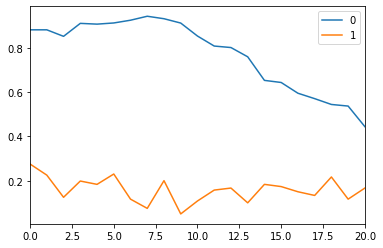

In [18]:
plotting[[0,1]].plot()

#### Ideally, the minimum cutoff should be sloping down from an initial peak at the first run and should either have a downward trend or have a valley

##### If the cutoff plot simply levels off immediately, adjust your estimators down to weaken them as much as possible

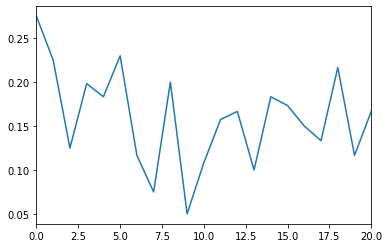

In [19]:
plotting[1].plot()

In [20]:
len(score_dfs)

22

In [21]:
plotting[1] = plotting[1].round(4)

In [22]:
plateau_score = plotting.iloc[-1,1]
top_scores = plotting[plotting[1] > plateau_score].iloc[1:]

if top_scores.empty:
    best_run = 0
else:
    best_run = top_scores[1].idxmax()
best_run

5

In [23]:
top_scores.head()

,0,1
1,0.880515,0.2250
3,0.909612,0.1983
4,0.906148,0.1833
5,0.911417,0.2300
8,0.930541,0.2000


In [24]:
print(classification_report(score_dfs[best_run]['org'], score_dfs[best_run]['pred']))

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       149
           1       0.82      0.97      0.89       249

    accuracy                           0.85       398
   macro avg       0.88      0.81      0.83       398
weighted avg       0.86      0.85      0.84       398



In [25]:
fpr, tpr, _ = roc_curve(score_dfs[best_run]['org'], score_dfs[best_run][0], pos_label=0)
roc_auc = auc(fpr, tpr)

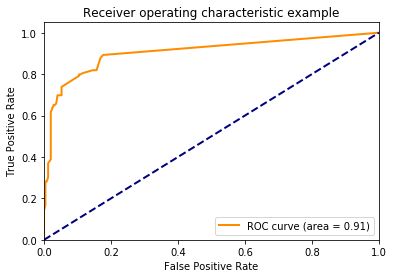

In [26]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [27]:
len(continuity_labels)

391

# Predict on holdout data

In [28]:
len(known_labels)

45

In [29]:
best_labels = pd.Series(np.ones(data_x.shape[0]))
best_labels.loc[labeling[best_run]] = 0

In [30]:
best_labels.value_counts()

1.0    295
0.0    103
dtype: int64

In [31]:
##### Uncomment me to see how a newly train classifier generalizes

best_clf = RandomForestClassifier(n_estimators=200, random_state=42)
best_clf.fit(data_x, best_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

##### Uncomment me to see how the original classifier performs

best_clf = clfs[best_run]
best_clf.fit(data_x, best_labels)

In [32]:
holdout_probs = pd.DataFrame(best_clf.predict_proba(test_x))

In [33]:
scores[best_run]

(0.9114174820085712, 0.22999999999999998)

## The threshold approach for predictions appears to tune a trade off between the recall ability of the newly trained model for higher precision

In [34]:
holdout_probs['pred'] = holdout_probs[0] < scores[best_run][1]
holdout_probs['pred'] = holdout_probs['pred'].astype(int)

In [35]:
holdout_preds = best_clf.predict(test_x)

In [36]:
print(classification_report(holdout_preds, test_y))

              precision    recall  f1-score   support

         0.0       0.73      0.98      0.84        47
         1.0       0.99      0.86      0.92       124

    accuracy                           0.89       171
   macro avg       0.86      0.92      0.88       171
weighted avg       0.92      0.89      0.90       171



In [37]:
holdout_preds = holdout_probs['pred']

In [38]:
print(classification_report(holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        62
           1       0.95      0.94      0.95       109

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [39]:
fpr, tpr, _ = roc_curve(holdout_preds, test_y, pos_label=1)
roc_auc = auc(fpr, tpr)

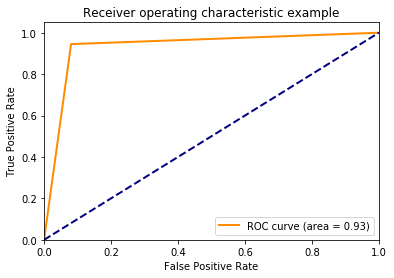

In [40]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [41]:
benchmark_labels = pd.Series(np.ones(data_x.shape[0]))
benchmark_labels.loc[known_labels] = 0

In [42]:
benchmark_clf = RandomForestClassifier(n_estimators=150, random_state=42)
benchmark_clf.fit(data_x, benchmark_labels)
benchmark_clf.fit(data_x, data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
benchmark_holdout_probs = pd.DataFrame(benchmark_clf.predict_proba(test_x))

In [44]:
benchmark_holdout_preds = benchmark_clf.predict(test_x)

In [45]:
print("PSEUDOLABELED: {} :: VERSUS :: BENCHMARK {}".format(f1_score(holdout_preds, test_y).round(4),
                                                     f1_score(benchmark_holdout_preds, test_y).round(4)))

PSEUDOLABELED: 0.9493 :: VERSUS :: BENCHMARK 0.9772


In [46]:
print(classification_report(holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        62
           1       0.95      0.94      0.95       109

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [47]:
print(classification_report(benchmark_holdout_preds, test_y))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        60
           1       0.99      0.96      0.98       111

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [48]:
fpr, tpr, _ = roc_curve(benchmark_holdout_preds, test_y, pos_label=1)
roc_auc = auc(fpr, tpr)

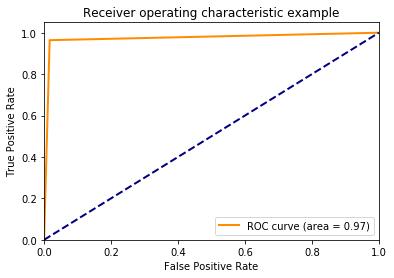

In [49]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()